In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.5
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0673

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - loss: 0.0526
Average validation loss: 0.5463625192642212
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - loss: 0.0526 - val_loss: 0.5464
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - loss: 0.0366 - val_loss: 0.5464
Average validation loss: 0.3316446542739868
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 509ms/step - loss: 0.0366 - val_loss: 0.4390
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 501ms/step - loss: 0.0275 - val_loss: 0.4390
Average validation loss: 0.3992033004760742
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 511ms/step - loss: 0.0275 - val_loss: 0.4257
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - loss: 0.0218 - val_loss: 0.4257
Average validation loss: 0.4264

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 483ms/step - loss: 1.5801e-05
Average validation loss: 0.0851711705327034
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - loss: 1.5801e-05 - val_loss: 0.0852
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step - loss: 1.6439e-05 - val_loss: 0.0852
Average validation loss: 0.08536641672253609
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 491ms/step - loss: 1.6439e-05 - val_loss: 0.0853
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 483ms/step - loss: 1.6595e-05 - val_loss: 0.0853
Average validation loss: 0.06558354757726192
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - loss: 1.6595e-05 - val_loss: 0.0787
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_10.pth'.
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 483ms/step - loss: 1.6339e-05 - val_loss: 0.0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 487ms/step - loss: 3.9754e-06
Average validation loss: 0.025172242584327858
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 494ms/step - loss: 3.9754e-06 - val_loss: 0.0252
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 484ms/step - loss: 3.7909e-06 - val_loss: 0.0252
Average validation loss: 0.010156050013999144
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - loss: 3.7909e-06 - val_loss: 0.0177
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 486ms/step - loss: 3.6365e-06 - val_loss: 0.0177
Average validation loss: 0.0163451104114453
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 493ms/step - loss: 3.6365e-06 - val_loss: 0.0172
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 484ms/step - loss: 3.5428e-

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 487ms/step - loss: 3.3463e-06
Average validation loss: 0.016133771743625402
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 495ms/step - loss: 3.3463e-06 - val_loss: 0.0161
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 487ms/step - loss: 2.6587e-06 - val_loss: 0.0161
Average validation loss: 0.007011059788055718
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 495ms/step - loss: 2.6587e-06 - val_loss: 0.0116
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 487ms/step - loss: 2.2024e-06 - val_loss: 0.0116
Average validation loss: 0.016575097339227796
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 494ms/step - loss: 2.2024e-06 - val_loss: 0.0132
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 486ms/step - loss: 1.9782

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 488ms/step - loss: 3.1833e-06
Average validation loss: 0.0036051371833309533
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step - loss: 3.1833e-06 - val_loss: 0.0036
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step - loss: 2.1862e-06 - val_loss: 0.0036
Average validation loss: 0.003963743150234222
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 496ms/step - loss: 2.1862e-06 - val_loss: 0.0038
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 489ms/step - loss: 1.7282e-06 - val_loss: 0.0038
Average validation loss: 0.0059496045112609865
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 497ms/step - loss: 1.7282e-06 - val_loss: 0.0045
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 489ms/step - loss: 1.4658e-06 - val_loss: 0.0045
Average validation loss: 0.0030045592226088046
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 496ms/step - loss: 1.4658e-06 - val_loss: 0.0041
Sa

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 489ms/step - loss: 1.1544e-06
Average validation loss: 0.007169263243364791
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 497ms/step - loss: 1.1544e-06 - val_loss: 0.0072
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 489ms/step - loss: 1.1436e-06 - val_loss: 0.0072
Average validation loss: 0.0028086784101712206
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 497ms/step - loss: 1.1436e-06 - val_loss: 0.0050
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 489ms/step - loss: 9.7839e-07 - val_loss: 0.0050
Average validation loss: 0.003188338344140599
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 496ms/step - loss: 9.7839e-07 - val_loss: 0.0044
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 485ms/step - loss: 8.2

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 489ms/step - loss: 4.1794e-06
Average validation loss: 0.02987243332900107
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 496ms/step - loss: 4.1794e-06 - val_loss: 0.0299
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 487ms/step - loss: 2.9917e-06 - val_loss: 0.0299
Average validation loss: 0.018907930911518635
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 495ms/step - loss: 2.9917e-06 - val_loss: 0.0244
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 485ms/step - loss: 2.4145e-06 - val_loss: 0.0244
Average validation loss: 0.0153968496597372
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 493ms/step - loss: 2.4145e-06 - val_loss: 0.0214
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\wei

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 488ms/step - loss: 7.4233e-06
Average validation loss: 0.5637135853370031
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 495ms/step - loss: 7.4233e-06 - val_loss: 0.5637
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 484ms/step - loss: 8.5165e-06 - val_loss: 0.5637
Average validation loss: 0.022220511183453102
48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 491ms/step - loss: 8.5165e-06 - val_loss: 0.2930
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 487ms/step - loss: 7.9644e-06 - val_loss: 0.2930
Average validation loss: 0.009805502942375218
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 495ms/step - loss: 7.9644e-06 - val_loss: 0.1986
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\we

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 488ms/step - loss: 7.0425e-06
Average validation loss: 0.0070864591980353
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 495ms/step - loss: 7.0425e-06 - val_loss: 0.0071
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 484ms/step - loss: 4.4413e-06 - val_loss: 0.0071
Average validation loss: 0.004587622575594911
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 491ms/step - loss: 4.4413e-06 - val_loss: 0.0058
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 487ms/step - loss: 3.3132e-06 - val_loss: 0.0058
Average validation loss: 0.006425127669769738
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 494ms/step - loss: 3.3132e-06 - val_loss: 0.0060
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 488ms/step - loss: 2.657

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - loss: 1.4913e-06
Average validation loss: 0.0070150602696230635
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 495ms/step - loss: 1.4913e-06 - val_loss: 0.0070
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 63s 487ms/step - loss: 1.0652e-06 - val_loss: 0.0070
Average validation loss: 0.02328560160822235
64/64 ━━━━━━━━━━━━━━━━━━━━ 63s 495ms/step - loss: 1.0652e-06 - val_loss: 0.0152
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 95s 488ms/step - loss: 1.6236e-06 - val_loss: 0.0152
Average validation loss: 0.008282646827865392
64/64 ━━━━━━━━━━━━━━━━━━━━ 95s 495ms/step - loss: 1.6236e-06 - val_loss: 0.0129
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 126s 486ms/step - loss: 1.6655e-06 - val_loss: 0.0129
Average validation loss: 0.011864482119563036
64/64 ━━━━━━━━━━━━━━━━━━━━ 127s 493ms/step - loss: 1.6655e-06 - val_loss: 0.0126
Epo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 488ms/step - loss: 1.1748e-06
Average validation loss: 0.027179880015965965
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 496ms/step - loss: 1.1748e-06 - val_loss: 0.0272
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 71s 488ms/step - loss: 8.4252e-07 - val_loss: 0.0272
Average validation loss: 0.04381397475178043
72/72 ━━━━━━━━━━━━━━━━━━━━ 71s 496ms/step - loss: 8.4252e-07 - val_loss: 0.0355
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 106s 485ms/step - loss: 8.1676e-07 - val_loss: 0.0355
Average validation loss: 0.06497967377718952
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 492ms/step - loss: 8.1676e-07 - val_loss: 0.0453
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 142s 489ms/step - loss: 7.0193e-07 - val_loss: 0.0453
Average validation loss: 0.007469975104969408
72/72 ━━━━━━━━━━━━━━━━━━━━ 143s 496ms/step - loss: 7.0193e-07 - val_loss: 0.0359
Sav

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 488ms/step - loss: 1.0886e-06
Average validation loss: 0.014817247889004648
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 496ms/step - loss: 1.0886e-06 - val_loss: 0.0148
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 79s 487ms/step - loss: 6.9709e-07 - val_loss: 0.0148
Average validation loss: 0.01670345349702984
80/80 ━━━━━━━━━━━━━━━━━━━━ 79s 494ms/step - loss: 6.9709e-07 - val_loss: 0.0158
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 118s 486ms/step - loss: 5.3761e-07 - val_loss: 0.0158
Average validation loss: 0.019845277117565275
80/80 ━━━━━━━━━━━━━━━━━━━━ 119s 493ms/step - loss: 5.3761e-07 - val_loss: 0.0171
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 158s 488ms/step - loss: 4.5533e-07 - val_loss: 0.0171
Average validation loss: 0.013167502568103373
80/80 ━━━━━━━━━━━━━━━━━━━━ 158s 495ms/step - loss: 4.5533e-07 - val_loss: 0.0161
S

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 486ms/step - loss: 9.3432e-06
Average validation loss: 0.03384469042066485
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 493ms/step - loss: 9.3432e-06 - val_loss: 0.0338
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 94s 488ms/step - loss: 6.9450e-06 - val_loss: 0.0338
Average validation loss: 0.04859441476097951
96/96 ━━━━━━━━━━━━━━━━━━━━ 95s 495ms/step - loss: 6.9450e-06 - val_loss: 0.0412
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 141s 485ms/step - loss: 5.7818e-06 - val_loss: 0.0412
Average validation loss: 0.1149617158031712
96/96 ━━━━━━━━━━━━━━━━━━━━ 142s 493ms/step - loss: 5.7818e-06 - val_loss: 0.0658
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 189s 486ms/step - loss: 4.5849e-06 - val_loss: 0.0658
Average validation loss: 0.10257628195298214
96/96 ━━━━━━━━━━━━━━━━━━━━ 190s 493ms/step - loss: 4.5849e-06 - val_loss: 0.0750
Epoch

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 58s 486ms/step - loss: 3.8059e-06
Average validation loss: 0.037042724202668374
120/120 ━━━━━━━━━━━━━━━━━━━━ 59s 494ms/step - loss: 3.8059e-06 - val_loss: 0.0370
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 118s 487ms/step - loss: 2.4015e-06 - val_loss: 0.0370
Average validation loss: 0.01850664986607929
120/120 ━━━━━━━━━━━━━━━━━━━━ 119s 495ms/step - loss: 2.4015e-06 - val_loss: 0.0278
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 177s 486ms/step - loss: 1.8493e-06 - val_loss: 0.0278
Average validation loss: 0.011550275019059579
120/120 ━━━━━━━━━━━━━━━━━━━━ 178s 494ms/step - loss: 1.8493e-06 - val_loss: 0.0224
Saved model weights to 'c:\天_11157065\git\Ripple

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - loss: 3.2598e-06
Average validation loss: 0.05746643631745327
144/144 ━━━━━━━━━━━━━━━━━━━━ 71s 496ms/step - loss: 3.2598e-06 - val_loss: 0.0575
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 141s 485ms/step - loss: 2.2307e-06 - val_loss: 0.0575
Average validation loss: 0.08190226113543354
144/144 ━━━━━━━━━━━━━━━━━━━━ 142s 492ms/step - loss: 2.2307e-06 - val_loss: 0.0697
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 212s 484ms/step - loss: 1.7902e-06 - val_loss: 0.0697
Average validation loss: 0.03795365704892598
144/144 ━━━━━━━━━━━━━━━━━━━━ 213s 491ms/step - loss: 1.7902e-06 - val_loss: 0.0591
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_180.pth'.
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 283s 487ms

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 78s 486ms/step - loss: 3.3429e-06
Average validation loss: 0.019030783030029853
160/160 ━━━━━━━━━━━━━━━━━━━━ 79s 494ms/step - loss: 3.3429e-06 - val_loss: 0.0190
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 157s 485ms/step - loss: 2.5203e-06 - val_loss: 0.0190
Average validation loss: 0.012489404517691583
160/160 ━━━━━━━━━━━━━━━━━━━━ 158s 493ms/step - loss: 2.5203e-06 - val_loss: 0.0158
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 236s 487ms/step - loss: 1.9736e-06 - val_loss: 0.0158
Average validation loss: 0.00961372316814959
160/160 ━━━━━━━━━━━━━━━━━━━━ 237s 495ms/step - loss: 1.9736e-06 - val_loss: 0.0137
Saved model weights to 'c:\天_11157065\git\Ripple

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 100s 501ms/step - loss: 1.7874e-06
Average validation loss: 0.008943819295382127
200/200 ━━━━━━━━━━━━━━━━━━━━ 102s 509ms/step - loss: 1.7874e-06 - val_loss: 0.0089
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 202s 500ms/step - loss: 1.2652e-06 - val_loss: 0.0089
Average validation loss: 0.0076793745055329056
200/200 ━━━━━━━━━━━━━━━━━━━━ 203s 507ms/step - loss: 1.2652e-06 - val_loss: 0.0083
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 303s 501ms/step - loss: 1.0759e-06 - val_loss: 0.0083
Average validation loss: 0.01239932843396673
200/200 ━━━━━━━━━━━━━━━━━━━━ 305s 508ms/step - loss: 1.0759e-06 - val_loss: 0.0097
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 405s 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 120s 500ms/step - loss: 1.8531e-06
Average validation loss: 0.008911308831739007
240/240 ━━━━━━━━━━━━━━━━━━━━ 122s 508ms/step - loss: 1.8531e-06 - val_loss: 0.0089
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 242s 501ms/step - loss: 1.3583e-06 - val_loss: 0.0089
Average validation loss: 0.009528079391263116
240/240 ━━━━━━━━━━━━━━━━━━━━ 244s 509ms/step - loss: 1.3583e-06 - val_loss: 0.0092
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 364s 501ms/step - loss: 1.1596e-06 - val_loss: 0.0092
Average validation loss: 0.011953455068093415
240/240 ━━━━━━━━━━━━━━━━━━━━ 366s 509ms/step - loss: 1.1596e-06 - val_loss: 0.0101
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 486s 499ms/step - loss: 9.9540e-07 - val_loss: 0.0101
Average validation loss: 0.010805757259610497
240/240 ━━━━━━━━━━━━━━━━━━━━ 488s 507ms/step - loss: 9.9540e-07

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.0930696064606309, 0.04503144585061818, 0.011643190052515517, 0.01144326062349137, 0.004987578550353647, 0.005621861719992012, 0.09463731449551414, 0.024093339338335986, 0.015231968093763237, 0.03148035644553602, 0.01948636926141464, 0.019180634522577747, 0.20712712401640598, 0.15588204860250218, 0.04911048639581887, 0.031067312899195967, 0.014006979417279535, 0.022021095017755968]
std_val_losses =  [0.10868126856945615, 0.04627754011799633, 0.01303276929851508, 0.012505151549652292, 0.004547641303200688, 0.00838835787816548, 0.10118747013924859, 0.077779846447767, 0.0198242318834296, 0.025625420178664617, 0.013452389481651547, 0.013419366699373578, 0.17294061713794914, 0.11875903579877614, 0.04027684424012354, 0.025798652845488053, 0.005809338429476023, 0.018533443289508258]


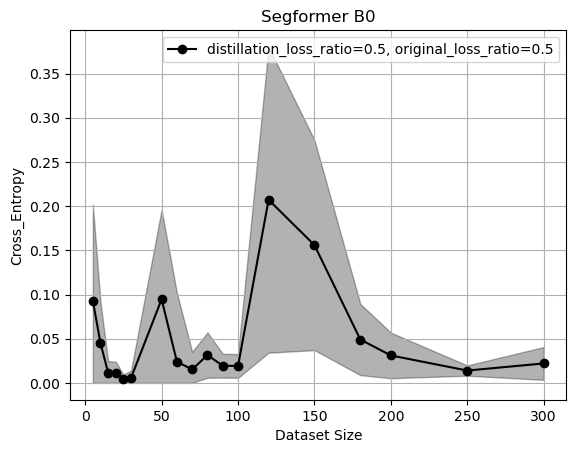

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()